In [1]:
# Import necessary libraries for data manipulation, text processing, and machine learning
import numpy as np
import pandas as pd
from nltk.tokenize.regexp import RegexpTokenizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec, KeyedVectors
from scipy.spatial.distance import cosine
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn plotting style for visuals
sns.set(style='darkgrid', context='talk')

# Define the initial text corpus for analysis
text = [
    "The prince is the future king.",
    "Daughter is the princess.",
    "Son is the prince.",
    "Only a man can be a king.",
    "Only a woman can be a queen.",
    "The princess will be a queen.",
    "Queen and king rule the realm.",
    "The prince is a strong man.",
    "The princess is a beautiful woman.",
    "The royal family is the king and queen and their children.",
    "Prince is only a boy now.",
    "A boy will be a man."
]


2024-02-18 21:22:35.723688: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define a function to preprocess text by tokenizing and removing stopwords
def preprocess_text(document):
    tokeniser = RegexpTokenizer(r"[A-Za-z]{2,}")  # Tokenize words of at least two letters
    tokens = tokeniser.tokenize(document.lower())  # Convert to lowercase
    key_tokens = [token for token in tokens if token not in stopwords.words('english')]  # Remove stopwords
    return key_tokens
    
# Process each document in the corpus
corpus = []
for document in text:
    corpus.append(preprocess_text(document))
# Display the processed corpus
corpus


[['prince', 'future', 'king'],
 ['daughter', 'princess'],
 ['son', 'prince'],
 ['man', 'king'],
 ['woman', 'queen'],
 ['princess', 'queen'],
 ['queen', 'king', 'rule', 'realm'],
 ['prince', 'strong', 'man'],
 ['princess', 'beautiful', 'woman'],
 ['royal', 'family', 'king', 'queen', 'children'],
 ['prince', 'boy'],
 ['boy', 'man']]

In [3]:
# Define a function to preprocess text by tokenizing and removing stopwords
def preprocess_text(document):
    tokeniser = RegexpTokenizer(r"[A-Za-z]{2,}")  # Tokenize words of at least two letters
    tokens = tokeniser.tokenize(document.lower())  # Convert to lowercase
    key_tokens = [token for token in tokens if token not in stopwords.words('english')]  # Remove stopwords
    return key_tokens
    
# Process each document in the corpus
corpus = []
for document in text:
    corpus.append(preprocess_text(document))
# Display the processed corpus
corpus


[['prince', 'future', 'king'],
 ['daughter', 'princess'],
 ['son', 'prince'],
 ['man', 'king'],
 ['woman', 'queen'],
 ['princess', 'queen'],
 ['queen', 'king', 'rule', 'realm'],
 ['prince', 'strong', 'man'],
 ['princess', 'beautiful', 'woman'],
 ['royal', 'family', 'king', 'queen', 'children'],
 ['prince', 'boy'],
 ['boy', 'man']]

In [4]:
# Set parameters for the Word2Vec model
dimension = 2
window = 2
# Train the Word2Vec model
word2vec0 = Word2Vec(corpus, min_count=1, vector_size=dimension, window=window, sg=1)

# Retrieve the vector for 'king'
word2vec0.wv.get_vector('king')


array([0.25516748, 0.45046365], dtype=float32)

In [5]:
# Define the number of similar words to retrieve
n = 3
# Find and display words most similar to 'king'
word2vec0.wv.most_similar(positive=['king'], topn=n)

# Create a DataFrame to hold word embeddings
embedding0 = pd.DataFrame(columns=['d0', 'd1'])
for token in word2vec0.wv.index_to_key:
    embedding0.loc[token] = word2vec0.wv.get_vector(token)
# Display the embedding DataFrame
embedding0


,d0,d1
queen,-0.026811,0.011822
king,0.255167,0.450464
prince,-0.465198,-0.355929
man,0.322944,0.448649
princess,-0.250771,-0.188169
woman,0.369025,-0.076674
boy,-0.226831,0.327703
royal,-0.243008,-0.090801
beautiful,0.143829,0.049594
strong,-0.414221,-0.472374


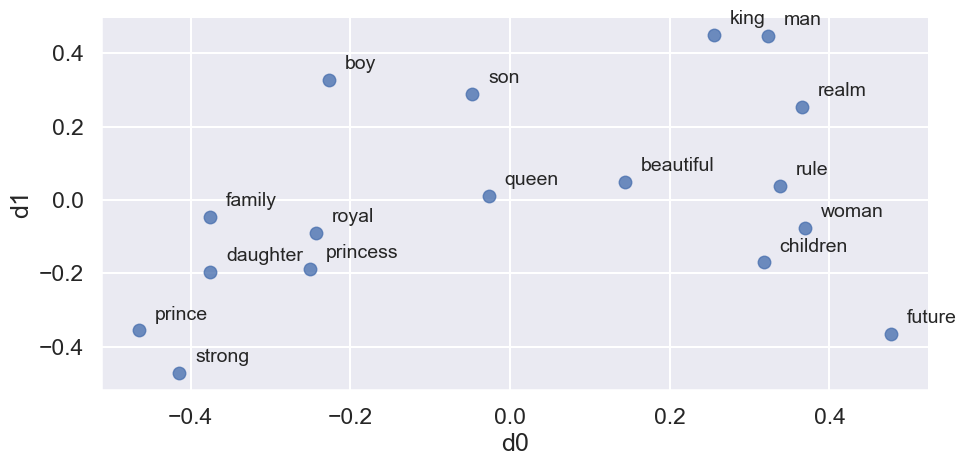

In [6]:
# Plot the word embeddings using Seaborn
sns.lmplot(data=embedding0, x='d0', y='d1', fit_reg=False, aspect=2)
# Annotate the plot with word labels
for token, vector in embedding0.iterrows():
    plt.gca().text(vector['d0']+.02, vector['d1']+.03, str(token), size=14)
plt.tight_layout()


In [7]:
# Create a sorted vocabulary list and mapping from tokens to indices
vocabulary = sorted([*set([token for document in corpus for token in document])])
n_vocabulary = len(vocabulary)
token_index = {token: i for i, token in enumerate(vocabulary)}
# Display the token to index mapping
token_index


{'beautiful': 0,
 'boy': 1,
 'children': 2,
 'daughter': 3,
 'family': 4,
 'future': 5,
 'king': 6,
 'man': 7,
 'prince': 8,
 'princess': 9,
 'queen': 10,
 'realm': 11,
 'royal': 12,
 'rule': 13,
 'son': 14,
 'strong': 15,
 'woman': 16}

In [8]:
# Generate token pairs considering the window size around each token
token_pairs = []
for document in corpus:
    for i, token in enumerate(document):
        for j in range(i-window, i+window+1):
            if (j >= 0) and (j != i) and (j < len(document)):
                token_pairs.append([token] + [document[j]])
n_token_pairs = len(token_pairs)
# Display the number of token pairs and the first few pairs
print(f"{n_token_pairs} token pairs")
token_pairs[:5]


56 token pairs


[['prince', 'future'],
 ['prince', 'king'],
 ['future', 'prince'],
 ['future', 'king'],
 ['king', 'prince']]

In [9]:
# Initialize matrices for input (X) and output (Y) of the model
X = np.zeros((n_token_pairs, n_vocabulary))
Y = np.zeros((n_token_pairs, n_vocabulary))
# Populate the matrices based on token pairs
for i, (focus_token, context_token) in enumerate(token_pairs):    
    X[i, token_index[focus_token]] = 1
    Y[i, token_index[context_token]] = 1
# Display the first few rows of the input matrix
print(X[:5])


[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [10]:
# Set a seed for reproducibility
tf.random.set_seed(42)
# Define a Sequential model with an embedding layer and a softmax output layer
word2vec1 = Sequential([
    Dense(units=dimension, input_shape=(n_vocabulary,), use_bias=False, name='embedding'),
    Dense(units=n_vocabulary, activation='softmax', name='output')
])
# Compile the model with categorical crossentropy loss and the Adam optimizer
word2vec1.compile(loss='categorical_crossentropy', optimizer='adam')
# Train the model on the input and output matrices
word2vec1.fit(x=X, y=Y, epochs=100)


Epoch 1/100
2/2 [==============================] - 0s 6ms/step - loss: 2.8401
Epoch 2/100
2/2 [==============================] - 0s 4ms/step - loss: 2.8383
Epoch 3/100
2/2 [==============================] - 0s 5ms/step - loss: 2.8368
Epoch 4/100
2/2 [==============================] - 0s 7ms/step - loss: 2.8352
Epoch 5/100
2/2 [==============================] - 0s 4ms/step - loss: 2.8337
Epoch 6/100
2/2 [==============================] - 0s 6ms/step - loss: 2.8322
Epoch 7/100
2/2 [==============================] - 0s 6ms/step - loss: 2.8308
Epoch 8/100
2/2 [==============================] - 0s 10ms/step - loss: 2.8293
Epoch 9/100
2/2 [==============================] - 0s 4ms/step - loss: 2.8279
Epoch 10/100
2/2 [==============================] - 0s 5ms/step - loss: 2.8264
Epoch 11/100
2/2 [==============================] - 0s 6ms/step - loss: 2.8249
Epoch 12/100
2/2 [==============================] - 0s 5ms/step - loss: 2.8235
Epoch 13/100
2/2 [==============================] - 0s 5ms/s

In [11]:
# Initialize a DataFrame to store embeddings from the trained Keras model
embedding1 = pd.DataFrame(columns=['d0', 'd1'])
# Extract embeddings for each token in the vocabulary using the model's weights
for token in token_index.keys():
    ind = token_index[token]
    embedding1.loc[token] = word2vec1.get_weights()[0][ind]
# Display the embeddings DataFrame
embedding1


,d0,d1
beautiful,0.544068,0.320557
boy,0.129622,-0.304491
children,0.329079,0.468792
daughter,0.220461,0.045910
family,0.386053,-0.410165
future,-0.043928,-0.366979
king,-0.261539,0.193979
man,-0.162378,0.239217
prince,0.229245,0.251135
princess,0.412694,-0.166747


In [12]:
# Retrieve the embedding vector for 'king'
vector1 = embedding1.loc['king']
similarities = {}
# Calculate cosine similarity between 'king' and all other vectors
for token, vector in embedding1.iterrows():
    theta_sum = np.dot(vector1, vector)
    theta_den = np.linalg.norm(vector1) * np.linalg.norm(vector)
    similarities[token] = theta_sum / theta_den
# Sort tokens by similarity and display the top n similar tokens
similar_tokens = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
similar_tokens[1:n+1]


[('royal', 0.99974585), ('man', 0.9439856), ('rule', 0.86401653)]

In [13]:
# Open a new text file and write the embeddings in a format compatible with KeyedVectors
with open('embedding1.txt', 'w') as text_file:
    text_file.write(f'{n_vocabulary} {dimension}\n')
    for token, vector in embedding1.iterrows():
        text_file.write(f"{token} {' '.join(map(str, vector))}\n")
text_file.close()  # This line is unnecessary as the with statement automatically closes the file
# Load the saved embeddings using KeyedVectors
embedding1_loaded = KeyedVectors.load_word2vec_format('embedding1.txt', binary=False)
# Display the most similar words to 'king' based on the loaded embeddings
embedding1_loaded.most_similar(positive=['king'], topn=n)


[('royal', 0.9997458457946777),
 ('man', 0.943985641002655),
 ('rule', 0.864016592502594)]

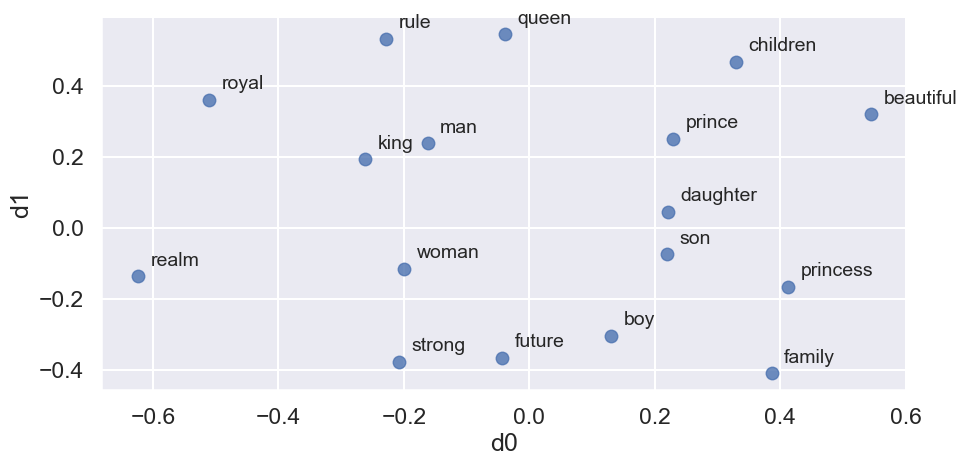

In [14]:
# Plot the embeddings using Seaborn's lmplot function for visual representation
sns.lmplot(data=embedding1, x='d0', y='d1', fit_reg=False, aspect=2)
# Annotate each point in the plot with its corresponding token
for token, vector in embedding1.iterrows():
    plt.gca().text(vector['d0']+.02, vector['d1']+.03, str(token), size=14)
plt.tight_layout()


In [15]:
# Define a class to encapsulate data preparation activities
class Data():
    def __init__(self, text):
        self.text = text  # Original text corpus
        self.corpus = self.extract_corpus()  # Processed corpus
    
    # Method to preprocess text: tokenize, lowercase, and remove stopwords
    def preprocess_text(self, document):
        tokeniser = RegexpTokenizer(r"[A-Za-z]{2,}")
        tokens = tokeniser.tokenize(document.lower())
        key_tokens = [token for token in tokens if token not in stopwords.words('english')]
        return key_tokens
    
    # Method to extract and preprocess corpus from the original text
    def extract_corpus(self):
        corpus = []
        for document in self.text:
            corpus.append(self.preprocess_text(document))
        return corpus
    
    # Method to one-hot encode a token based on the vocabulary
    def one_hot_encode(self, token):
        ohe_vector = np.zeros(self.n_vocabulary)
        ohe_vector[self.token_index[token]] = 1
        return ohe_vector
    
    # Prepare focus and context data for training the Word2Vec model
    def prepare_focus_context_data(self, window=2):
        self.window = window
        # Generate vocabulary and mappings from tokens to indices and vice versa
        self.vocabulary = sorted([*set([token for document in self.corpus for token in document])])
        self.n_vocabulary = len(self.vocabulary)
        self.token_index = {token: i for i, token in enumerate(self.vocabulary)}
        self.index_token = {i: token for token, i in self.token_index.items()}
        
        # Generate focus and context token data based on the window size
        self.focus_context_data = []
        for sentence in self.corpus:
            for i, token in enumerate(sentence):
                focus_token = self.one_hot_encode(token)
                context_tokens = []
                for j in range(i-window, i+window+1):
                    if (j != i) and (j <= len(sentence)-1) and (j >= 0):
                        context_tokens.append(self.one_hot_encode(sentence[j]))
                self.focus_context_data.append((focus_token, context_tokens))

# Instantiate the Data class and prepare data
data = Data(text)
data.prepare_focus_context_data()
# Display the processed corpus
data.corpus


[['prince', 'future', 'king'],
 ['daughter', 'princess'],
 ['son', 'prince'],
 ['man', 'king'],
 ['woman', 'queen'],
 ['princess', 'queen'],
 ['queen', 'king', 'rule', 'realm'],
 ['prince', 'strong', 'man'],
 ['princess', 'beautiful', 'woman'],
 ['royal', 'family', 'king', 'queen', 'children'],
 ['prince', 'boy'],
 ['boy', 'man']]

In [16]:
# Display the total number of tokens in the processed corpus
len([token for document in data.corpus for token in document])
# Display the total number of focus-context pairs prepared for training
len(data.focus_context_data)
# Summarize the total number of context tokens across all pairs
np.sum([len(context_tokens) for _, context_tokens in data.focus_context_data])


56

In [17]:
# Define a custom Word2Vec model class
class Word2Vec():
    def __init__(self, dimension):
        self.dimension = dimension  # Dimensionality of the word embeddings
        
    # Method to train the model on the prepared data
    def train(self, data, learning_rate, epochs, seed=24):
        self.data = data
        np.random.seed(seed)
        # Initialize weight matrices
        self.w1 = np.random.uniform(-1, 1, (data.n_vocabulary, self.dimension))
        self.w2 = np.random.uniform(-1, 1, (self.dimension, data.n_vocabulary))

        # Training loop
        for i in range(epochs):
            self.loss = 0
            for focus_token, context_tokens in data.focus_context_data:
                y_pred, hidden, output = self.forward_pass(focus_token)
                # Calculate error and perform backpropagation
                error = np.sum([np.subtract(y_pred, token) for token in context_tokens], axis=0)
                self.backprop(error, hidden, focus_token, learning_rate)
                # Update loss
                self.loss += -np.sum([output[token.argmax()] for token in context_tokens]) + len(context_tokens) * np.log(np.sum(np.exp(output)))
            print(f"Epoch: {i} | Loss: {self.loss}")

    # Forward pass through the network
    def forward_pass(self, x):
        hidden = np.dot(x, self.w1)
        output = np.dot(hidden, self.w2)
        y_pred = self.softmax(output)
        return y_pred, hidden, output

    # Softmax activation function
    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)

    # Backpropagation to update weights
    def backprop(self, error, hidden, x, learning_rate):
        dl_dw2 = np.outer(hidden, error)
        dl_dw1 = np.outer(x, np.dot(self.w2, error.T))
        self.w1 -= learning_rate * dl_dw1
        self.w2 -= learning_rate * dl_dw2
    
    # Extract vector for a given token
    def extract_vector(self, token):
        index = self.data.token_index[token]
        vector = self.w1[index]
        return vector
    
    # Find words similar to a given token
    def find_similar_words(self, token, n=3):
        vector1 = self.extract_vector(token)
        similarities = {}
        for i in range(self.data.n_vocabulary):
            vector2 = self.w1[i]
            similarities[data.index_token[i]] = 1 - cosine(vector1, vector2)
        similar_tokens = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
        return similar_tokens[1:n+1]
        
# Instantiate and train the custom Word2Vec model
word2vec2 = Word2Vec(dimension=dimension)
word2vec2.train(data, learning_rate=0.01, epochs=50)


Epoch: 0 | Loss: 167.32393447944256
Epoch: 1 | Loss: 166.4644789481025
Epoch: 2 | Loss: 165.67349538552088
Epoch: 3 | Loss: 164.94241324581006
Epoch: 4 | Loss: 164.2638588460181
Epoch: 5 | Loss: 163.63145912768562
Epoch: 6 | Loss: 163.03968133528898
Epoch: 7 | Loss: 162.48370139207063
Epoch: 8 | Loss: 161.95929534293526
Epoch: 9 | Loss: 161.46274943868838
Epoch: 10 | Loss: 160.99078535941896
Epoch: 11 | Loss: 160.54049778955974
Epoch: 12 | Loss: 160.1093021146592
Epoch: 13 | Loss: 159.69489044764185
Epoch: 14 | Loss: 159.29519453800546
Epoch: 15 | Loss: 158.9083543917501
Epoch: 16 | Loss: 158.5326916485353
Epoch: 17 | Loss: 158.166686937637
Epoch: 18 | Loss: 157.80896057494732
Epoch: 19 | Loss: 157.45825607670034
Epoch: 20 | Loss: 157.11342605738628
Epoch: 21 | Loss: 156.77342015380586
Epoch: 22 | Loss: 156.43727467784473
Epoch: 23 | Loss: 156.1041037500296
Epoch: 24 | Loss: 155.77309170639333
Epoch: 25 | Loss: 155.4434866043468
Epoch: 26 | Loss: 155.1145946804661
Epoch: 27 | Loss: 154

In [18]:
# Extract the vector for 'king' using the custom Word2Vec model
word2vec2.extract_vector('king')
# Find words similar to 'king' using the custom model
word2vec2.find_similar_words("king")
# Create a DataFrame to hold embeddings from the custom Word2Vec model
embedding2 = pd.DataFrame(word2vec2.w1, columns=['d0', 'd1'])
# Map DataFrame indices to tokens using the index_token mapping
embedding2.index = embedding2.index.map(word2vec2.data.index_token)
# Display the embedding DataFrame
embedding2


,d0,d1
beautiful,0.971068,0.177538
boy,0.436580,-0.482706
children,-0.389786,1.107146
daughter,0.712422,-0.279001
family,-0.613740,0.226625
future,-0.772410,-0.081598
king,0.041056,0.466855
man,-0.361068,-0.040430
prince,0.086255,0.338579
princess,0.413813,0.450000


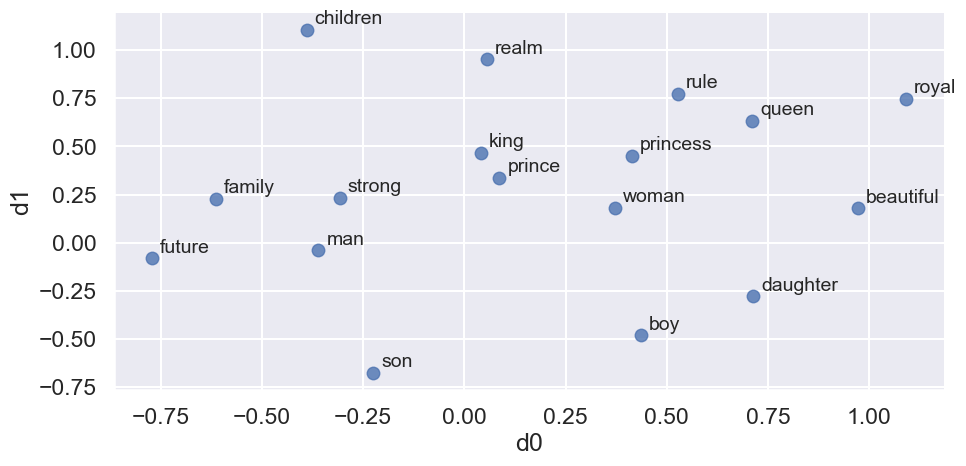

In [19]:
# Plot the embeddings from the custom Word2Vec model
sns.lmplot(data=embedding2, x='d0', y='d1', fit_reg=False, aspect=2)
# Annotate the plot with token labels
for token, vector in embedding2.iterrows():
    plt.gca().text(vector['d0']+.02, vector['d1']+.03, str(token), size=14)
plt.tight_layout()


In [20]:
# Save embeddings to a text file in a format compatible with KeyedVectors
with open('embedding2.txt', 'w') as text_file:
    text_file.write(f'{n_vocabulary} {dimension}\n')
    for token, vector in embedding2.iterrows():
        text_file.write(f"{token} {' '.join(map(str, vector))}\n")
text_file.close()  # This line is unnecessary as the with statement automatically closes the file
# Load the embeddings from the text file using KeyedVectors
embedding2_loaded = KeyedVectors.load_word2vec_format('embedding2.txt', binary=False)
# Display the most similar words to 'king' based on the custom model's embeddings
embedding2_loaded.most_similar(positive=['king'], topn=n)


[('realm', 0.9995501041412354),
 ('prince', 0.9869499206542969),
 ('children', 0.9105312824249268)]